# Tutorial 3: Flatfielding

### Further reading:

The ccdproc reference doc:
https://ccdproc.readthedocs.io/

Image reduction cookbook:
https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/index.html


## Import the packages

In [6]:
# Support Posix paths. Takes care of OS specific paths.
from pathlib import Path

# The usual libs
import numpy as np
import matplotlib.pyplot as plt

# Astropy
# The tools in ccdproc accept only CCDData objects
from astropy.nddata import CCDData

from astropy.stats import mad_std
from astropy.modeling import models
from astropy.io import fits

#ccdproc
import ccdproc as ccdp
from ccdproc import ImageFileCollection



## i/o stuff: define paths, create file lists

In [7]:
read_path = Path('proc')
write_path = Path('proc')

#Make an image file collection for the OTZ corrected files
imcol = ImageFileCollection(read_path, glob_include='ZOT_*')  

#imcol.summary['file', 'imagetyp', 'object', 'filter', 'exptime']
list_flatV = imcol.files_filtered(filter='V', imagetyp='FLAT',include_path=True)
list_flatI = imcol.files_filtered(filter='I', imagetyp='FLAT',include_path=True)
imcol_flatV = imcol.filter(filter='V', imagetyp='FLAT')
imcol_flatI = imcol.filter(filter='I', imagetyp='FLAT')

list_flatI, list_flatV

(['proc/ZOT_4081f.fits',
  'proc/ZOT_4082f.fits',
  'proc/ZOT_4083f.fits',
  'proc/ZOT_4084f.fits',
  'proc/ZOT_4085f.fits',
  'proc/ZOT_4086f.fits',
  'proc/ZOT_4087f.fits'],
 ['proc/ZOT_4075f.fits',
  'proc/ZOT_4076f.fits',
  'proc/ZOT_4078f.fits',
  'proc/ZOT_4079f.fits',
  'proc/ZOT_4080f.fits'])

In [8]:
# Each filter has its own flat
# Create list of filters

#flat_filters = set(h['filter'] for h in imcol.headers(imagetyp='FLAT'))
#flat_filters = np.array(np.unique(imcol.summary['filter']))
flat_filters = np.unique(imcol.summary['filter'])

flat_filters

I
V


In [5]:
# check iteration through the filter list
for filt in flat_filters:
    print(filt)


I
V


## Combine the flats

Differently from the bias images, flatfield images have different count levels which must be put on a common scale (normalised) before combining.

Full documentation on the combine function: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html#ccdproc.combine

[[46023. 40670. 31636. 27819. 24605. 33732. 29106. 25333. 21813. 18817.
  26140. 21971.]
 [46064. 40706. 31662. 27842. 24625. 33823. 29155. 25375. 21853. 18846.
  26184. 22007.]]


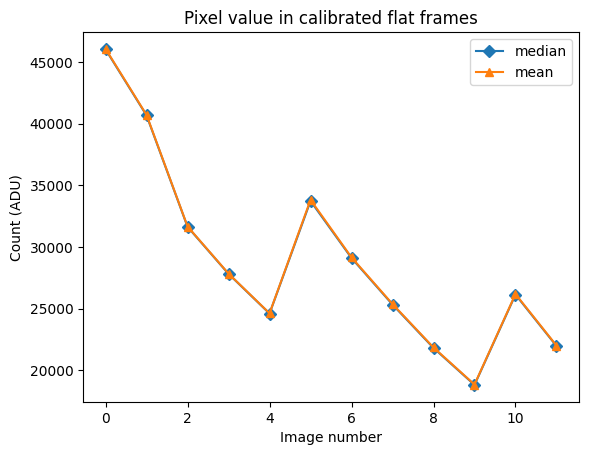

In [5]:
#Might want to avoid the edges
imsection = np.index_exp[5:1020,5:1020]
median_count = [np.median(data[imsection]) for data in imcol.data(imagetyp='FLAT')]
mean_count = [np.mean(data[imsection]) for data in imcol.data(imagetyp='FLAT')]

#median_count = [np.median(data) for data in imcol.data(imagetyp='FLAT')]
#mean_count = [np.mean(data) for data in imcol.data(imagetyp='FLAT')]

plt.plot(median_count,'D-', label='median')
plt.plot(mean_count,'^-', label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(np.around([median_count,mean_count]))

In [9]:
# In this example, we scale the images to the median value. 
# For that we need to define a function:

def inv_median(a):
    return 1 / np.median(a)

In [12]:
for filt in flat_filters:
    to_combine = imcol.files_filtered(imagetyp='FLAT', filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )
    combined_flat.meta['combined'] = True
    flat_name = 'Flat_{}.fits'.format(filt.replace("''", "p"))
    combined_flat.write(write_path / flat_name, overwrite=True)

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


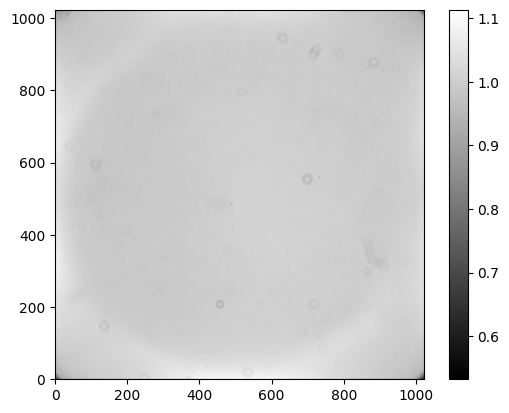

In [14]:
# There seems to be a problem in one of the flats. try to fix it
plt.imshow(fits.open('./proc/Flat_I.fits')[0].data, cmap='gray', origin='lower')
plt.colorbar()
## o artefacto da estrela desaparece quase completamente se anteriormente aplicarmos um fator 2 (simetrico) no sigma_clip

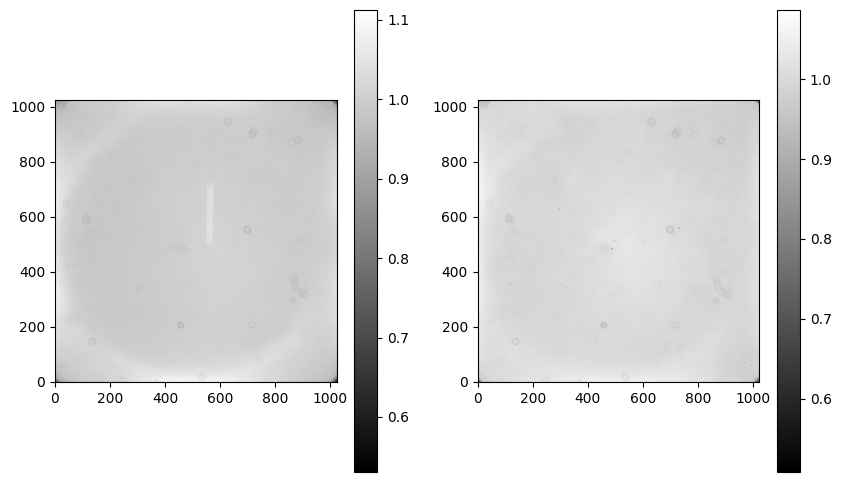

In [13]:
proc_path = './proc/'

flat_i = 'Flat_I.fits'
flat_v = 'Flat_V.fits'

hdu_flat_i = fits.open(proc_path+flat_i)
hdu_flat_v = fits.open(proc_path+flat_v)

data_flat_i = hdu_flat_i[0].data
data_flat_v = hdu_flat_v[0].data

#Plot original images
nrow = 1
ncol = 2
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.imshow(data_flat_i, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,2)
plt.imshow(data_flat_v, cmap='gray', origin='lower')
plt.colorbar()


## Flatfield correct the science (object) images

In [22]:
# Filter by filter
# Lets read the master flatfield images from disk
for filt in flat_filters:
    flat = CCDData.read(str(write_path)+'/Flat_'+str(filt)+'.fits')
    # Now select just the the object images
    imcol_objects = imcol.filter(imagetyp='object', filter=filt)
    for ccd, file_name in imcol_objects.ccds(return_fname=True):
        ccd = ccdp.flat_correct(ccd, flat)
        ccd.header['flatcor'] = 'Flat_'+str(filt)
        # Save the result
        ccd.write(str(write_path)+'/F'+file_name, overwrite=True)


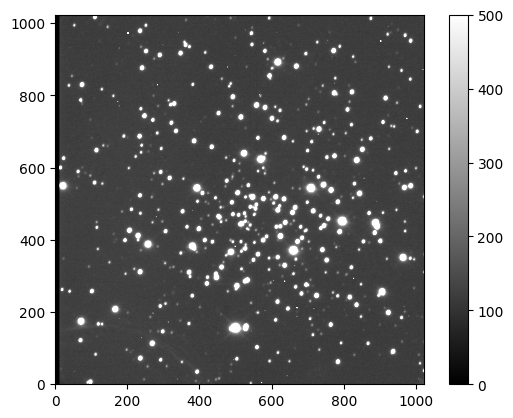

In [23]:
#Show last image
plt.imshow(ccd.data, cmap='gray', origin='lower', vmin=0, vmax=500)
plt.colorbar()

In [30]:
ccd.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
ORIGIN  = 'Copyright (C) 1991-1998 GKR Computer Consulting' / FITS file originat
DATE    = '2001-06-06T00:19:27' / Date FITS file was generated                  
IRAF-TLM= '15:49:41 (05/06/2001)' / Time of last modification                   
EXPTIME =                  180                                                  
FILTER  = 'V       '                                                            
IMAGETYP= 'OBJECT  '                                                            
CCDSUM  = '1 1     '        